In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import torch
import torchvision
import torchsummary
import torchmetrics
from sklearn.metrics import average_precision_score
from torch.utils.tensorboard import SummaryWriter

In [3]:
from utils import do_train, predict_test

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
NAME_MODEL = 'ResNet50'

In [6]:
if torch.cuda.is_available():
    print('There is GPU')

There is GPU


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
CANTIDAD_CLASES = 2
ANCHO_IMAGENES = 224
ALTO_IMAGENES = 224

In [9]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.ImageFolder(root='P2datasetFull/train/', transform=data_transforms)
valid_set = torchvision.datasets.ImageFolder(root='P2datasetFull/val1/', transform=data_transforms)
test_set = torchvision.datasets.ImageFolder(root='P2datasetFull/test1/', transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [10]:
from torchvision.models import resnet50, ResNet50_Weights
weights = ResNet50_Weights.IMAGENET1K_V1
transforms = weights.transforms()

model = torchvision.models.resnet50(weights=weights)

model.to(device)

torchsummary.summary(model, input_size=(3, 224, 224))
model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

In [11]:
for param in model.parameters():
    param.requires_grad = False

In [12]:
last_layer_in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

In [13]:
model_optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_loss = torch.nn.CrossEntropyLoss()
model_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
model_data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

model_writer = {"train": SummaryWriter(log_dir=f"data_{NAME_MODEL}/{NAME_MODEL}_model_train"),
                "valid": SummaryWriter(log_dir=f"data_{NAME_MODEL}/{NAME_MODEL}_model_valid")}

history = do_train(model.to("cpu"), 
                model_optimizer, 
                model_loss, 
                model_metric,
                model_data,
                20,
                device,
                model_writer)

Epoch: 1/20 - Train loss 0.436299 - Train Accuracy 0.848693 - Valid Loss 0.307789 - Valid Accuracy 0.915570
Epoch: 2/20 - Train loss 0.256226 - Train Accuracy 0.927786 - Valid Loss 0.232232 - Valid Accuracy 0.928205
Epoch: 3/20 - Train loss 0.212455 - Train Accuracy 0.933281 - Valid Loss 0.200982 - Valid Accuracy 0.930929
Epoch: 4/20 - Train loss 0.188328 - Train Accuracy 0.935746 - Valid Loss 0.187178 - Valid Accuracy 0.934702
Epoch: 5/20 - Train loss 0.174537 - Train Accuracy 0.941167 - Valid Loss 0.175442 - Valid Accuracy 0.937019
Epoch: 6/20 - Train loss 0.165458 - Train Accuracy 0.943485 - Valid Loss 0.168420 - Valid Accuracy 0.938782
Epoch: 7/20 - Train loss 0.159494 - Train Accuracy 0.944932 - Valid Loss 0.165645 - Valid Accuracy 0.937907
Epoch: 8/20 - Train loss 0.159754 - Train Accuracy 0.940529 - Valid Loss 0.162030 - Valid Accuracy 0.939189
Epoch: 9/20 - Train loss 0.146265 - Train Accuracy 0.950182 - Valid Loss 0.159263 - Valid Accuracy 0.937586
Epoch: 10/20 - Train loss 0.

In [14]:
torch.save(model.state_dict(), f'{NAME_MODEL}.pth')

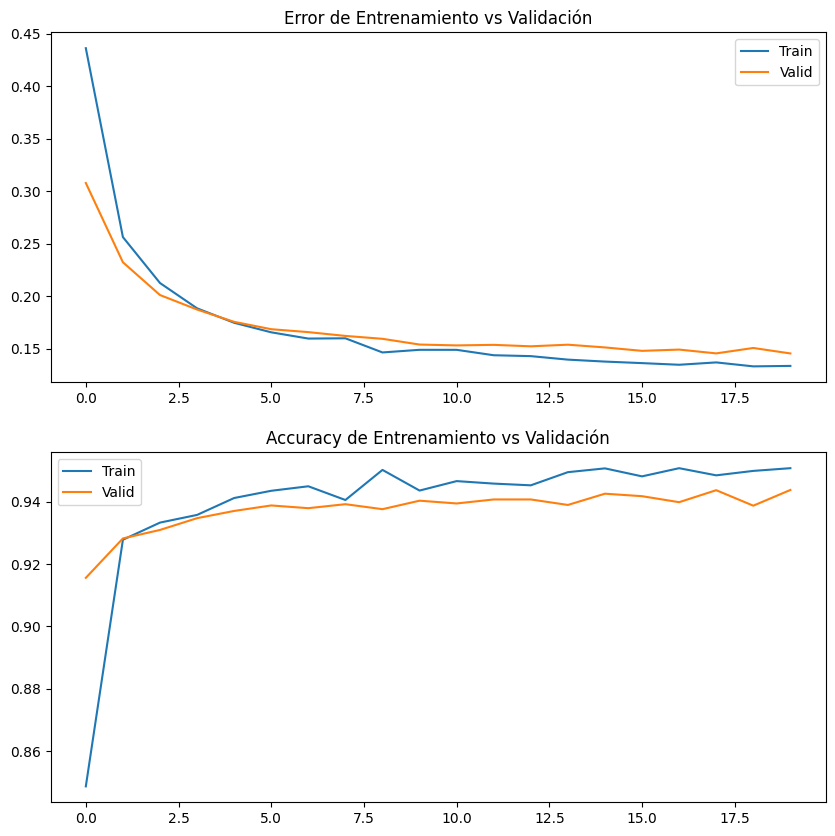

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [16]:
predict_test(model, test_loader)

Total images: 6216
PR_AUC: 0.9862562657031428
Accuracy: 94.86808236808237
